Loading voter file: ../StateData/CaliforniaData/CA_2022_prim_l2_vf_2020blocks/CA_2022_prim_l2_vf_2020blocks.csv


/var/folders/z9/gzbgl18s2wgcr125qq0q2h280000gn/T/ipykernel_192/265273115.py:221: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['060014001001009' '060014001001010' '060014001001011' ...
 '061150411021039' '061150411021040' '061150411021047']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_active.loc[:, VF_BLOCK_ID_COL] = df_active[VF_BLOCK_ID_COL].astype(str).str.zfill(15)


Aggregating voter data to Census Tracts...
Aggregated voter data for 9086 tracts.
Loading CVAP data: ../StateData/CaliforniaData/ca_cvap_2022_2020_b/ca_cvap_2022_2020_b.csv


/var/folders/z9/gzbgl18s2wgcr125qq0q2h280000gn/T/ipykernel_192/265273115.py:252: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['060372060201002' '060679883001003' '060952530001007' ...
 '060014001001002' '060014001001001' '060014001001000']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_cvap.loc[:, CVAP_BLOCK_ID_COL] = df_cvap[CVAP_BLOCK_ID_COL].astype(str).str.zfill(15)


Aggregating CVAP data to Census Tracts and calculating percentages...
Aggregated CVAP data for 9080 tracts.
Loading Tract shapefile: ../StateData/CaliforniaData/ca_t_2020_bound/ca_t_2020_bound.shp
Loading District shapefile: ../StateData/CaliforniaData/ca_cong_adopted_2021/CD_Final 2021-12-20.shp
Merging tract-level data...
Merged data for 9086 tracts with geometries.
Performing spatial join (assigning tracts to districts)...
Assigned 9086 tracts to districts.
Aggregating data to district level...
Calculating Polsby-Popper scores...
Calculating Efficiency Gap...
Calculating Community Concentration (Threshold: >30.0%) ...
Analyzing: Black (using pct_black) - Found 357 tracts statewide >30.0% CVAP.
Analyzing: Hispanic (using pct_hispanic) - Found 4076 tracts statewide >30.0% CVAP.
Analyzing: Asian (using pct_asian) - Found 1266 tracts statewide >30.0% CVAP.

--- METRIC SUMMARY ---
State: California

Polsby-Popper Scores:
 DISTRICT  polsby_popper
        1         0.2197
       10        

/var/folders/z9/gzbgl18s2wgcr125qq0q2h280000gn/T/ipykernel_192/265273115.py:337: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gdf_districts_final.fillna(0, inplace=True) # Fill NaNs for districts with no matching tracts/data



Saved detailed district metrics to GeoJSON in ../results/CA/
Saved compactness map to ../results/CA/

Analysis for California complete. Results in ../results/CA/


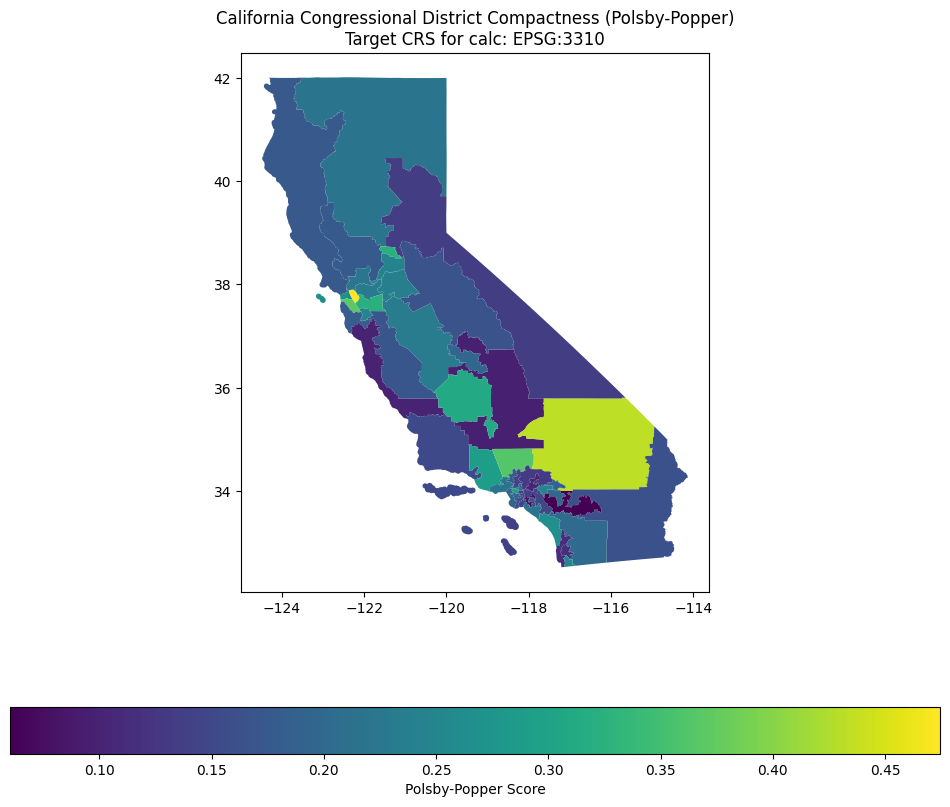

In [1]:
# === California Gerrymandering Analysis Script ===

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt # For plotting compactness
import json
import os

# --- California Specific Configuration ---
# !!! IMPORTANT: REVIEW AND UPDATE THESE VALUES FOR YOUR CALIFORNIA DATA !!!
STATE_ABBR = "CA"
STATE_NAME = "California"

# --- File Paths ---
# (Adjust these paths relative to where you run the script, or use absolute paths)
BASE_DATA_PATH = "../StateData/CaliforniaData/" # Base directory for this state's data
VOTER_FILE_PATH = os.path.join(BASE_DATA_PATH, "CA_2022_prim_l2_vf_2020blocks/CA_2022_prim_l2_vf_2020blocks.csv")
CVAP_FILE_PATH = os.path.join(BASE_DATA_PATH, "ca_cvap_2022_2020_b/ca_cvap_2022_2020_b.csv")
DISTRICT_SHAPEFILE_PATH = os.path.join(BASE_DATA_PATH, "ca_cong_adopted_2021/CD_Final 2021-12-20.shp") # GUESS - VERIFY
TRACT_SHAPEFILE_PATH = os.path.join(BASE_DATA_PATH, "ca_t_2020_bound/ca_t_2020_bound.shp")

# --- Target CRS for Geometric Calculations (Area, Perimeter) ---
# NAD83 / California Albers is good for statewide area calculations in California
TARGET_CRS_EPSG = "EPSG:3310"

# --- Key Column Names (VERIFY THESE AGAINST YOUR ACTUAL FILES) ---
# Voter File Columns
VF_BLOCK_ID_COL = 'geoid20' # 15-digit block GEOID in voter file
VF_TOTAL_REG_COL = 'total_reg'
VF_PARTY_DEM_COL = 'party_dem'
VF_PARTY_REP_COL = 'party_rep'
VF_PARTY_NPP_COL = 'party_npp' # Non-Partisan/Other
VF_GENERAL_2020_VOTES_COL = 'g20201103' # L2 column for 2020 General Election turnout

# CVAP File Columns
CVAP_BLOCK_ID_COL = 'GEOID20' # 15-digit block GEOID in CVAP file
CVAP_TOTAL_COL = 'CVAP_TOT22'
CVAP_WHITE_COL = 'CVAP_WHT22'
CVAP_BLACK_COL = 'CVAP_BLK22'
CVAP_HISPANIC_COL = 'CVAP_HSP22'
CVAP_ASIAN_COL = 'CVAP_ASN22'
CVAP_AIAN_COL = 'CVAP_AIA22' # American Indian/Alaska Native
CVAP_NHPI_COL = 'CVAP_NHP22' # Native Hawaiian/Pacific Islander

# Tract Shapefile Columns
TRACT_SHP_ID_COL = 'GEOID20' # 11-digit tract GEOID in tract shapefile

# District Shapefile Columns
DISTRICT_SHP_ID_COL = 'DISTRICT' # Or 'CD118FP', 'DISTRICTNO', etc. VERIFY!

# --- Community Concentration Analysis Parameters ---
COMMUNITY_THRESHOLD_PCT = 30.0
MINORITY_GROUPS_FOR_ANALYSIS = { # Internal name : CVAP column name in tract_cvap
    'black': 'pct_black',
    'hispanic': 'pct_hispanic',
    'asian': 'pct_asian'
    # Add 'aian': 'pct_aian', 'nhpi': 'pct_nhpi' if desired and data supports it
}
# Corresponding CVAP raw count columns for aggregation to districts
CVAP_RAW_COLS_FOR_DIST_AGG = {
    'CVAP_TOT22': CVAP_TOTAL_COL,
    'CVAP_BLK22': CVAP_BLACK_COL,
    'CVAP_HSP22': CVAP_HISPANIC_COL,
    'CVAP_ASN22': CVAP_ASIAN_COL,
    'CVAP_AIA22': CVAP_AIAN_COL,
    'CVAP_NHP22': CVAP_NHPI_COL
}


# --- Output Directory ---
RESULTS_DIR = f"../results/CA/"
os.makedirs(RESULTS_DIR, exist_ok=True)

# --- Helper Functions (from previous work, slightly adapted) ---

def calculate_polsby_popper(gdf_districts_input, district_id_col, target_crs):
    """Calculates Polsby-Popper scores."""
    print("Calculating Polsby-Popper scores...")
    gdf_districts_scores = gdf_districts_input.copy()
    try:
        gdf_districts_proj = gdf_districts_scores.to_crs(target_crs)
    except Exception as e:
        print(f"Error reprojecting for Polsby-Popper: {e}. Using original CRS for geometry properties (may be less accurate).")
        gdf_districts_proj = gdf_districts_scores # Fallback, less accurate
        
    gdf_districts_proj['area'] = gdf_districts_proj.geometry.area
    gdf_districts_proj['perimeter'] = gdf_districts_proj.geometry.length
    gdf_districts_proj['polsby_popper'] = 0.0
    valid_perimeter = gdf_districts_proj['perimeter'] > 0
    gdf_districts_proj.loc[valid_perimeter, 'polsby_popper'] = \
        (4 * np.pi * gdf_districts_proj.loc[valid_perimeter, 'area']) / \
        (gdf_districts_proj.loc[valid_perimeter, 'perimeter']**2)
    gdf_districts_scores['polsby_popper'] = gdf_districts_proj['polsby_popper'].fillna(0)
    return gdf_districts_scores[[district_id_col, 'polsby_popper']]

def calculate_efficiency_gap(gdf_districts_input, district_id_col, dem_votes_col, rep_votes_col):
    """Calculates the Efficiency Gap."""
    print("Calculating Efficiency Gap...")
    df_results = gdf_districts_input[[district_id_col, dem_votes_col, rep_votes_col]].copy()
    # Standardize column names for calculation
    df_results.rename(columns={district_id_col: 'DISTRICT', dem_votes_col: 'Dem_Votes', rep_votes_col: 'Rep_Votes'}, inplace=True)

    df_results['Total_Votes'] = df_results['Dem_Votes'] + df_results['Rep_Votes']
    df_results['Win_Threshold'] = np.floor(df_results['Total_Votes'] / 2) + 1
    df_results['Wasted_Dem_Votes'] = 0.0
    df_results['Wasted_Rep_Votes'] = 0.0

    dem_wins = df_results['Dem_Votes'] > df_results['Rep_Votes']
    rep_wins = df_results['Rep_Votes'] > df_results['Dem_Votes']
    tie = df_results['Dem_Votes'] == df_results['Rep_Votes']

    df_results.loc[dem_wins, 'Wasted_Dem_Votes'] = df_results['Dem_Votes'] - df_results['Win_Threshold']
    df_results.loc[rep_wins | tie, 'Wasted_Dem_Votes'] = df_results['Dem_Votes']
    df_results.loc[rep_wins, 'Wasted_Rep_Votes'] = df_results['Rep_Votes'] - df_results['Win_Threshold']
    df_results.loc[dem_wins | tie, 'Wasted_Rep_Votes'] = df_results['Rep_Votes']

    df_results['Wasted_Dem_Votes'] = df_results['Wasted_Dem_Votes'].clip(lower=0)
    df_results['Wasted_Rep_Votes'] = df_results['Wasted_Rep_Votes'].clip(lower=0)

    total_votes_statewide = df_results['Total_Votes'].sum()
    total_wasted_dem = df_results['Wasted_Dem_Votes'].sum()
    total_wasted_rep = df_results['Wasted_Rep_Votes'].sum()

    efficiency_gap_value = (total_wasted_rep - total_wasted_dem) / total_votes_statewide if total_votes_statewide > 0 else 0
    return efficiency_gap_value, df_results

def calculate_community_concentration(gdf_tracts_with_district_input, district_id_col, minority_pct_cols_map, threshold_pct):
    """Calculates community concentration."""
    print(f"Calculating Community Concentration (Threshold: >{threshold_pct}%) ...")
    gdf_tracts_with_district = gdf_tracts_with_district_input.copy() # Avoid modifying original
    concentration_results = []
    distribution_details_list = []
    
    if district_id_col not in gdf_tracts_with_district.columns:
        raise KeyError(f"District ID column '{district_id_col}' not found in input GeoDataFrame.")
        
    num_districts = gdf_tracts_with_district[district_id_col].nunique()
    if num_districts == 0:
        print("Warning: No districts found. Skipping community concentration.")
        return pd.DataFrame(), pd.DataFrame()
    baseline_even_spread = 1 / num_districts

    all_districts = sorted(gdf_tracts_with_district[district_id_col].unique())
    district_summary_base = pd.DataFrame({district_id_col: all_districts})

    for group_key, pct_col_name in minority_pct_cols_map.items(): # e.g., group_key='black', pct_col_name='pct_black'
        group_name_display = group_key.capitalize()
        high_conc_col = f'high_{group_key}_cvap_{threshold_pct}' # Temporary column

        if pct_col_name not in gdf_tracts_with_district.columns:
            print(f"Warning: CVAP percentage column '{pct_col_name}' for group '{group_name_display}' not found. Skipping.")
            # Append empty info for summary and details
            concentration_results.append({
                'Minority Group': group_name_display, 'Threshold (%)': threshold_pct,
                'Total High-Conc Tracts Statewide': 0, 'Concentration Score (Sum Sq Shares)': np.nan,
                'Baseline Even Spread': baseline_even_spread, 'Interpretation': 'Skipped - Data missing'
            })
            empty_df = pd.DataFrame({district_id_col: all_districts, f'high_{group_key}_tracts': 0, f'share_statewide_high_{group_key}': 0.0})
            distribution_details_list.append(empty_df)
            continue

        gdf_tracts_with_district.loc[:, high_conc_col] = gdf_tracts_with_district[pct_col_name] > threshold_pct
        total_high_conc_tracts_statewide = gdf_tracts_with_district[high_conc_col].sum()
        print(f"Analyzing: {group_name_display} (using {pct_col_name}) - Found {total_high_conc_tracts_statewide} tracts statewide >{threshold_pct}% CVAP.")

        high_tracts_col_name = f'high_{group_key}_tracts'
        share_col_name = f'share_statewide_high_{group_key}'

        if total_high_conc_tracts_statewide > 0:
            dist_group_summary = gdf_tracts_with_district[gdf_tracts_with_district[high_conc_col]].groupby(district_id_col).size().reset_index(name=high_tracts_col_name)
            dist_group_summary = pd.merge(district_summary_base, dist_group_summary, on=district_id_col, how='left').fillna(0)
            dist_group_summary[high_tracts_col_name] = dist_group_summary[high_tracts_col_name].astype(int)
            dist_group_summary[share_col_name] = dist_group_summary[high_tracts_col_name] / total_high_conc_tracts_statewide
            
            concentration_score = (dist_group_summary[share_col_name]**2).sum()
            
            mid_point = (baseline_even_spread + 1.0) / 2
            lower_bound = baseline_even_spread + (mid_point - baseline_even_spread) * 0.5 
            upper_bound = mid_point + (1.0 - mid_point) * 0.5
            if concentration_score >= upper_bound: interpretation = f"High Concentration / Packing (Score: {concentration_score:.3f})"
            elif concentration_score <= lower_bound: interpretation = f"Dispersed / Potential Cracking (Score: {concentration_score:.3f})"
            else: interpretation = f"Moderate Concentration / Uneven Split (Score: {concentration_score:.3f})"
        else:
            concentration_score = np.nan
            interpretation = "No tracts above threshold"
            dist_group_summary = district_summary_base.copy()
            dist_group_summary[high_tracts_col_name] = 0
            dist_group_summary[share_col_name] = 0.0
            
        distribution_details_list.append(dist_group_summary[[district_id_col, high_tracts_col_name, share_col_name]])
        concentration_results.append({
            'Minority Group': group_name_display, 'Threshold (%)': threshold_pct,
            'Total High-Conc Tracts Statewide': total_high_conc_tracts_statewide,
            'Concentration Score (Sum Sq Shares)': concentration_score,
            'Baseline Even Spread': baseline_even_spread, 'Interpretation': interpretation
        })
        gdf_tracts_with_district.drop(columns=[high_conc_col], inplace=True, errors='ignore')

    final_distribution_df = district_summary_base.copy()
    for detail_df in distribution_details_list:
        final_distribution_df = pd.merge(final_distribution_df, detail_df, on=district_id_col, how='left', suffixes=('', '_y'))
        # Clean up potential duplicate columns from merge if a group was skipped then processed
        cols_to_drop = [col for col in final_distribution_df.columns if '_y' in col]
        final_distribution_df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

    return pd.DataFrame(concentration_results), final_distribution_df.fillna(0)

# --- Main Analysis Steps ---

# 1. Load Voter File Data
print(f"Loading voter file: {VOTER_FILE_PATH}")
try:
    df_vf = pd.read_csv(VOTER_FILE_PATH, low_memory=False)
except FileNotFoundError:
    print(f"ERROR: Voter file not found at {VOTER_FILE_PATH}. Exiting.")
    exit()

# Basic cleaning and prep for voter file
df_active = df_vf[df_vf[VF_TOTAL_REG_COL] > 0].copy()
df_active.loc[:, VF_BLOCK_ID_COL] = df_active[VF_BLOCK_ID_COL].astype(str).str.zfill(15)
df_active.loc[:, 'census_tract'] = df_active[VF_BLOCK_ID_COL].str[:11]

# Calculate estimated votes
# Ensure division by zero is handled if total_reg could be zero after filtering (though already filtered)
df_active.loc[:, 'dem_proportion'] = (df_active[VF_PARTY_DEM_COL] / df_active[VF_TOTAL_REG_COL]).fillna(0)
df_active.loc[:, 'rep_proportion'] = (df_active[VF_PARTY_REP_COL] / df_active[VF_TOTAL_REG_COL]).fillna(0)
df_active.loc[:, 'Estimated_Dem_Votes_2020'] = (df_active[VF_GENERAL_2020_VOTES_COL] * df_active['dem_proportion']).fillna(0)
df_active.loc[:, 'Estimated_Rep_Votes_2020'] = (df_active[VF_GENERAL_2020_VOTES_COL] * df_active['rep_proportion']).fillna(0)

# Aggregate voter data to tracts
print("Aggregating voter data to Census Tracts...")
tract_voter_agg = df_active.groupby('census_tract').agg(
    total_reg_tract=(VF_TOTAL_REG_COL, 'sum'),
    party_dem_tract=(VF_PARTY_DEM_COL, 'sum'),
    party_rep_tract=(VF_PARTY_REP_COL, 'sum'),
    # party_npp_tract=(VF_PARTY_NPP_COL, 'sum'), # If available and needed
    voted_general_2020_tract=(VF_GENERAL_2020_VOTES_COL, 'sum'),
    estimated_dem_votes_tract=('Estimated_Dem_Votes_2020', 'sum'),
    estimated_rep_votes_tract=('Estimated_Rep_Votes_2020', 'sum')
).reset_index()
print(f"Aggregated voter data for {len(tract_voter_agg)} tracts.")

# 2. Load CVAP Data
print(f"Loading CVAP data: {CVAP_FILE_PATH}")
try:
    df_cvap = pd.read_csv(CVAP_FILE_PATH)
except FileNotFoundError:
    print(f"ERROR: CVAP file not found at {CVAP_FILE_PATH}. Exiting.")
    exit()

df_cvap.loc[:, CVAP_BLOCK_ID_COL] = df_cvap[CVAP_BLOCK_ID_COL].astype(str).str.zfill(15)
df_cvap = df_cvap[df_cvap[CVAP_TOTAL_COL] > 0] # Filter out blocks with no CVAP
df_cvap.loc[:, 'census_tract'] = df_cvap[CVAP_BLOCK_ID_COL].str[:11]

# Aggregate CVAP to tracts and calculate percentages
print("Aggregating CVAP data to Census Tracts and calculating percentages...")
cvap_agg_dict = {CVAP_TOTAL_COL: 'sum', CVAP_WHITE_COL: 'sum', CVAP_BLACK_COL: 'sum',
                 CVAP_HISPANIC_COL: 'sum', CVAP_ASIAN_COL: 'sum', CVAP_AIAN_COL: 'sum', CVAP_NHPI_COL: 'sum'}
# Filter out any CVAP columns not present in the loaded df_cvap
cvap_agg_dict_filtered = {k: v for k, v in cvap_agg_dict.items() if k in df_cvap.columns}
tract_cvap = df_cvap.groupby('census_tract').agg(cvap_agg_dict_filtered).reset_index()

# Calculate CVAP percentages
for group_key, pct_col_name in MINORITY_GROUPS_FOR_ANALYSIS.items():
    raw_cvap_col = globals().get(f'CVAP_{group_key.upper()}_COL') # e.g., CVAP_BLACK_COL
    if raw_cvap_col and raw_cvap_col in tract_cvap.columns and CVAP_TOTAL_COL in tract_cvap.columns:
        tract_cvap[pct_col_name] = (tract_cvap[raw_cvap_col] / tract_cvap[CVAP_TOTAL_COL] * 100).fillna(0)
    else:
        print(f"Warning: Could not calculate {pct_col_name}, raw CVAP column missing or total CVAP missing.")
        tract_cvap[pct_col_name] = 0.0 # Default if calculation fails
print(f"Aggregated CVAP data for {len(tract_cvap)} tracts.")


# 3. Load Shapefiles
print(f"Loading Tract shapefile: {TRACT_SHAPEFILE_PATH}")
try:
    gdf_tract_shapes = gpd.read_file(TRACT_SHAPEFILE_PATH)
except Exception as e:
    print(f"ERROR: Could not load Tract shapefile: {e}. Exiting.")
    exit()
gdf_tract_shapes.loc[:, 'census_tract'] = gdf_tract_shapes[TRACT_SHP_ID_COL].astype(str).str.zfill(11)

print(f"Loading District shapefile: {DISTRICT_SHAPEFILE_PATH}")
try:
    gdf_districts = gpd.read_file(DISTRICT_SHAPEFILE_PATH)
except Exception as e:
    print(f"ERROR: Could not load District shapefile: {e}. Exiting.")
    exit()
# Clean and ensure district ID is integer
gdf_districts.loc[:, DISTRICT_SHP_ID_COL] = gdf_districts[DISTRICT_SHP_ID_COL].astype(str).str.replace(r'\D+', '', regex=True).fillna('0').astype(int)


# 4. Merge Data
print("Merging tract-level data...")
# Merge voter aggregates with tract_cvap
gdf_tracts_data = pd.merge(tract_voter_agg, tract_cvap, on='census_tract', how='left')
# Merge with tract geometries
gdf_tracts_merged = pd.merge(gdf_tract_shapes, gdf_tracts_data, on='census_tract', how='inner')
print(f"Merged data for {len(gdf_tracts_merged)} tracts with geometries.")

# 5. Spatial Join: Assign Tracts to Districts
print("Performing spatial join (assigning tracts to districts)...")
if gdf_districts.crs != gdf_tracts_merged.crs:
    print(f"Reprojecting tracts from {gdf_tracts_merged.crs} to {gdf_districts.crs} for spatial join.")
    gdf_tracts_merged = gdf_tracts_merged.to_crs(gdf_districts.crs)

# Use 'predicate="intersects"' for robustness, then remove duplicates by keeping the one with largest intersection or centroid within.
# For simplicity here, we use intersects and keep first. Consider more robust methods if needed.
gdf_tracts_with_district = gpd.sjoin(gdf_tracts_merged, gdf_districts[[DISTRICT_SHP_ID_COL, 'geometry']],
                                     how='left', predicate='intersects', lsuffix='tract', rsuffix='dist')
gdf_tracts_with_district.dropna(subset=[DISTRICT_SHP_ID_COL], inplace=True) # Remove tracts not assigned
gdf_tracts_with_district = gdf_tracts_with_district.drop_duplicates(subset=['census_tract'], keep='first')
gdf_tracts_with_district.loc[:, DISTRICT_SHP_ID_COL] = gdf_tracts_with_district[DISTRICT_SHP_ID_COL].astype(int)
print(f"Assigned {len(gdf_tracts_with_district)} tracts to districts.")

# 6. Aggregate Data to District Level
print("Aggregating data to district level...")
agg_dict_to_district = {
    'total_reg_tract': 'sum', 'party_dem_tract': 'sum', 'party_rep_tract': 'sum',
    'voted_general_2020_tract': 'sum', 'estimated_dem_votes_tract': 'sum',
    'estimated_rep_votes_tract': 'sum'
}
# Add CVAP raw count columns to aggregation dictionary
for internal_name, cvap_col in CVAP_RAW_COLS_FOR_DIST_AGG.items():
    if cvap_col in gdf_tracts_with_district.columns: # Check if column exists after merges
         agg_dict_to_district[cvap_col] = 'sum'
    else:
         print(f"Warning: CVAP column {cvap_col} not found in tract data for district aggregation, will be missing in final district data.")


district_aggregates = gdf_tracts_with_district.groupby(DISTRICT_SHP_ID_COL).agg(
    {k: v for k, v in agg_dict_to_district.items() if k in gdf_tracts_with_district.columns} # Ensure columns exist
).reset_index()

gdf_districts_final = pd.merge(gdf_districts, district_aggregates, on=DISTRICT_SHP_ID_COL, how='left')
gdf_districts_final.fillna(0, inplace=True) # Fill NaNs for districts with no matching tracts/data

# Calculate overall district CVAP percentages for context
for group_key, pct_col_name in MINORITY_GROUPS_FOR_ANALYSIS.items():
    raw_cvap_col = CVAP_RAW_COLS_FOR_DIST_AGG.get(f'CVAP_{group_key.upper()}22', None) # Get the raw CVAP col name
    dist_pct_col_name = f'pct_cvap_{group_key}_dist'
    if raw_cvap_col and raw_cvap_col in gdf_districts_final.columns and CVAP_TOTAL_COL in gdf_districts_final.columns and gdf_districts_final[CVAP_TOTAL_COL].sum() > 0:
        gdf_districts_final[dist_pct_col_name] = (gdf_districts_final[raw_cvap_col] / gdf_districts_final[CVAP_TOTAL_COL] * 100).fillna(0)
    else:
        gdf_districts_final[dist_pct_col_name] = 0.0


# 7. Calculate Gerrymandering Metrics
# Polsby-Popper
pp_scores_df = calculate_polsby_popper(gdf_districts_final, DISTRICT_SHP_ID_COL, TARGET_CRS_EPSG)
gdf_districts_final = pd.merge(gdf_districts_final, pp_scores_df, on=DISTRICT_SHP_ID_COL, how='left')

# Efficiency Gap
efficiency_gap_value, eg_details_df = calculate_efficiency_gap(
    gdf_districts_final, DISTRICT_SHP_ID_COL,
    'estimated_dem_votes_tract', 'estimated_rep_votes_tract'
)

# Community Concentration
# Ensure pct columns are present in gdf_tracts_with_district for the function
minority_pct_cols_for_func = {key: val for key, val in MINORITY_GROUPS_FOR_ANALYSIS.items() if val in gdf_tracts_with_district.columns}
if not minority_pct_cols_for_func:
    print("Warning: No valid CVAP percentage columns found in tract data for community concentration. Skipping.")
    comm_conc_summary_df = pd.DataFrame()
    comm_conc_details_df = pd.DataFrame()
else:
    comm_conc_summary_df, comm_conc_details_df = calculate_community_concentration(
        gdf_tracts_with_district, DISTRICT_SHP_ID_COL, # Use the district ID from tracts data
        minority_pct_cols_for_func,
        COMMUNITY_THRESHOLD_PCT
    )

# 8. Output Results
print("\n--- METRIC SUMMARY ---")
print(f"State: {STATE_NAME}")

print("\nPolsby-Popper Scores:")
print(gdf_districts_final[[DISTRICT_SHP_ID_COL, 'polsby_popper']].round(4).to_string(index=False))

print(f"\nEfficiency Gap: {efficiency_gap_value:.4f}")
if efficiency_gap_value < -0.0001: print(f"Interpretation: Favors Republicans by {abs(efficiency_gap_value):.2%}")
elif efficiency_gap_value > 0.0001: print(f"Interpretation: Favors Democrats by {efficiency_gap_value:.2%}")
else: print("Interpretation: Neutral")

print("\nCommunity Concentration Summary:")
if not comm_conc_summary_df.empty:
    summary_display = comm_conc_summary_df.copy()
    if 'Concentration Score (Sum Sq Shares)' in summary_display.columns:
        summary_display['Concentration Score (Sum Sq Shares)'] = summary_display['Concentration Score (Sum Sq Shares)'].map('{:.3f}'.format)
    if 'Baseline Even Spread' in summary_display.columns:
        summary_display['Baseline Even Spread'] = summary_display['Baseline Even Spread'].map('{:.3f}'.format)
    print(summary_display[['Minority Group', 'Total High-Conc Tracts Statewide', 'Concentration Score (Sum Sq Shares)', 'Baseline Even Spread', 'Interpretation']].to_string(index=False))
else:
    print("Community concentration analysis was skipped or produced no results.")


# Save detailed tables
eg_details_df.to_csv(os.path.join(RESULTS_DIR, f"{STATE_ABBR}_efficiency_gap_details.csv"), index=False)
if not comm_conc_details_df.empty:
    # Merge comm_conc_details_df with overall district CVAP % for the contextual view
    context_cols_to_select = [DISTRICT_SHP_ID_COL] + [f'pct_cvap_{gk}_dist' for gk in MINORITY_GROUPS_FOR_ANALYSIS.keys() if f'pct_cvap_{gk}_dist' in gdf_districts_final.columns]
    contextual_comm_conc_df = pd.merge(
        gdf_districts_final[context_cols_to_select],
        comm_conc_details_df,
        on=DISTRICT_SHP_ID_COL,
        how='left'
    )
    contextual_comm_conc_df.to_csv(os.path.join(RESULTS_DIR, f"{STATE_ABBR}_community_concentration_details_contextual.csv"), index=False)

# Save final GeoDataFrame with scores for potential front-end use
# Select only essential columns for smaller file size
cols_to_export = [DISTRICT_SHP_ID_COL, 'geometry', 'polsby_popper']
# Add estimated votes and CVAP percentages per district if useful for frontend
cols_to_export.extend(['estimated_dem_votes_tract', 'estimated_rep_votes_tract', CVAP_TOTAL_COL]) # CVAP_TOTAL_COL is the raw count here
for group_key in MINORITY_GROUPS_FOR_ANALYSIS.keys():
    cols_to_export.append(f'pct_cvap_{group_key}_dist')

# Filter for existing columns before exporting
final_export_cols = [col for col in cols_to_export if col in gdf_districts_final.columns]
gdf_districts_final[final_export_cols].to_file(os.path.join(RESULTS_DIR, f"{STATE_ABBR}_districts_metrics.geojson"), driver="GeoJSON")
print(f"\nSaved detailed district metrics to GeoJSON in {RESULTS_DIR}")

# Plot compactness scores
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf_districts_final.plot(column='polsby_popper', ax=ax, legend=True,
                         legend_kwds={'label': "Polsby-Popper Score", 'orientation': "horizontal"})
ax.set_title(f"{STATE_NAME} Congressional District Compactness (Polsby-Popper)\nTarget CRS for calc: {TARGET_CRS_EPSG}")
plt.savefig(os.path.join(RESULTS_DIR, f"{STATE_ABBR}_compactness_map.png"))
print(f"Saved compactness map to {RESULTS_DIR}")

print(f"\nAnalysis for {STATE_NAME} complete. Results in {RESULTS_DIR}")


California Congressional Map Analysis Summary (Based on 2020 Votes & Demographics)
I analyzed California's current congressional district map using three common metrics to assess potential gerrymandering:
1. Partisan Fairness (Efficiency Gap):
What it measures: How fairly the map translates statewide votes into seats for each party. It looks at "wasted votes" – votes cast for losing candidates or excess votes for winners that didn't affect the outcome. A large difference in wasted votes suggests the map favors one party.
Result: +4.76% (Favors Democrats)
Explanation: The Efficiency Gap is +4.76%, indicating a moderate advantage for the Democratic party in converting their statewide votes into congressional seats under the estimated 2020 voting patterns. While this suggests some partisan skew, the magnitude is not as extreme as seen in some other states.
2. District Shapes (Compactness - Polsby-Popper Score):
What it measures: How regular or sprawling a district's physical shape is. Scores range from 0 (very irregular) to 1 (a perfect circle). Very low scores can indicate manipulation, but geography also plays a role. California has 52 congressional districts.
Results:
Range: Scores vary significantly, from extremely non-compact (e.g., District 41: 0.0602, District 45: 0.0794, District 20: 0.0973, District 19: 0.0998) to moderately compact (e.g., District 12: 0.4745, District 23: 0.4333).

Overall: Many districts exhibit low to very low compactness scores, suggesting highly irregular shapes. For example, Districts 41, 45, 20, 19, 31, 50, and 51 all have scores below 0.15.

Explanation: California's districts, on average, display a tendency towards irregular shapes. Several districts have extremely low Polsby-Popper scores, which can be a flag for potential gerrymandering, although California's diverse geography and adherence to other criteria (like Voting Rights Act considerations and keeping cities/counties whole where possible) also influence district boundaries. The presence of multiple very non-compact districts warrants further investigation into the reasons behind their shapes.
3. Community Representation (Concentration of Minority CVAP Tracts at >30% Threshold):
What it measures: How Census Tracts with high concentrations of minority Citizen Voting Age Population (CVAP) are distributed across districts. The "Concentration Score" (Sum of Squared Shares) indicates if these communities are packed into few districts or cracked across many. For California's 52 districts, a perfectly even spread would yield a score of approximately 0.019 (1/52).
Results:
Black Communities:

Statewide: 357 Census Tracts have >30% Black CVAP.

Concentration Score: 0.121 (Interpretation: Dispersed / Potential Cracking, Score: 0.121).

Explanation: This score is notably higher than the baseline for even spread (0.019), indicating that while not extremely packed into a single district, the high-concentration Black tracts are distributed unevenly, with some districts holding a significantly larger share of these tracts than others. This could suggest that these communities are somewhat clustered or "packed" into certain districts, or potentially "cracked" if their numbers are split just enough to dilute influence in multiple areas. A deeper look at the share_statewide_high_black column in your detailed output would show which districts contain these larger shares.

Hispanic Communities:

Statewide: 4076 Census Tracts have >30% Hispanic CVAP (a very large number, indicating this community is widespread).

Concentration Score: 0.030 (Interpretation: Dispersed / Potential Cracking, Score: 0.030).

Explanation: This score is very close to the baseline for an even spread (0.019). This suggests that Census Tracts with high Hispanic CVAP concentrations are quite broadly distributed across many of California's 52 districts, rather than being heavily packed into only a few. This reflects the significant and widespread Hispanic population in the state.

Asian Communities:

Statewide: 1266 Census Tracts have >30% Asian CVAP.

Concentration Score: 0.046 (Interpretation: Dispersed / Potential Cracking, Score: 0.046).

Explanation: This score is also relatively low and closer to the baseline (0.019) than to high concentration. It indicates that high-concentration Asian CVAP tracts are also fairly dispersed across California's districts, though slightly less so than Hispanic tracts.

Explanation of Community Metrics:
The analysis suggests that for California, high-concentration Hispanic and Asian CVAP tracts are relatively dispersed across its numerous districts, with scores fairly close to what an even distribution would look like. High-concentration Black CVAP tracts show a higher concentration score, indicating a more uneven distribution across districts compared to the other two groups, though still categorized by the script as "Dispersed / Potential Cracking" relative to extreme packing.

Overall Takeaway:
This analysis of California's congressional map indicates a moderate partisan advantage for Democrats according to the Efficiency Gap (+4.76%). A key feature is the prevalence of highly irregular district shapes, with many districts exhibiting very low Polsby-Popper compactness scores.
Regarding community representation (at a >30% CVAP threshold), high-concentration Hispanic and Asian tracts appear relatively dispersed across the state's 52 districts. High-concentration Black tracts are also categorized as dispersed but show a more uneven distribution (higher concentration score) than the other two groups, suggesting some districts contain notably larger shares of these communities. The combination of irregular shapes and these demographic distribution patterns would require more detailed local examination to fully assess claims of gerrymandering.